In [ ]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical


In [ ]:
import os
import cv2

def resize_image(image_path):
    # Load the image and resize it to 128,128
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
    return img

def read_dataset(dataset_path):
    # Create a list to store all the images
    images = []
    # Create a list to store the labels
    labels = []
    # Loop through the folders in the dataset path
    for folder in os.listdir(dataset_path):
        # Check if the folder is either 'Testing' or 'Training'
        if folder in ['Testing', 'Training']:
            # Create the path to the folder
            folder_path = os.path.join(dataset_path, folder)
            # Loop through the sub-folders in the folder
            for sub_folder in os.listdir(folder_path):
                # Check if the sub-folder is one of the four categories
                if sub_folder in ['glioma', 'meningioma', 'notumor', 'pituitary']:
                    # Create the path to the sub-folder
                    sub_folder_path = os.path.join(folder_path, sub_folder)
                    # Loop through the images in the sub-folder
                    for image_file in os.listdir(sub_folder_path):
                        # Check if the image is a .jpg file
                        if image_file.endswith('.jpg'):
                            # Create the path to the image
                            image_path = os.path.join(sub_folder_path, image_file)
                            # Resize the image and add it to the list of images
                            images.append(resize_image(image_path))
                            # Add the label to the list of labels
                            labels.append(sub_folder)
    return images, labels


In [ ]:
# Call the read_dataset function to read the dataset
images, labels = read_dataset('/kaggle/input/brain-tumor-mri-dataset/')

In [ ]:
target = ['glioma', 'meningioma', 'notumor', 'pituitary']

def text_to_index(text_labels):
    index_labels = []
    for label in text_labels:
        index_labels.append(target.index(label))
    return index_labels

labels = text_to_index(labels)


In [ ]:
images=np.array(images)
labels=np.array(labels)
print(images.shape,labels.shape)
images = images / 255.0

(7023, 128, 128, 3) (7023,)


In [ ]:
print(labels)

[3 3 3 ... 0 0 0]


In [ ]:
from sklearn.model_selection import train_test_split
# Split the images and labels into training and testing sets, with a  test size
X_train, X_test, y_train, y_test = train_test_split(images,labels, test_size=0.2, random_state=42,stratify=labels)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5618, 128, 128, 3) (1405, 128, 128, 3) (5618,) (1405,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.applications.inception_v3 import InceptionV3

# Load the InceptionV3 model pre-trained on ImageNet without the top layers
base_model = InceptionV3(input_shape=(128, 128, 3), include_top=False, weights=None)
# We make all the layers trainable 
for layer in base_model.layers:
    layer.trainable = True

In [ ]:

x =base_model.output
# Add remaining layers
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
predictions = Dense(4, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
adam = Adam(lr=0.005)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
early_stop = EarlyStopping(patience=20, restore_best_weights=True)
tensorboard = TensorBoard(log_dir='./logs')


In [ ]:
y_train = to_categorical(y_train)
print(f"Label size {y_train.shape}")
y_test = to_categorical(y_test)
print(f"Label size {y_test.shape}")

Label size (5618, 4)
Label size (1405, 4)


In [ ]:

from keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with rotation and flip parameters
datagen = ImageDataGenerator(rotation_range=15, horizontal_flip=True, vertical_flip=True)
# Fit the generator to your training data
datagen.fit(X_train)


In [ ]:
import time

# start time
start_time = time.time()


history = model.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[checkpoint, early_stop])

# end time
end_time = time.time()

# calculate total time taken
total_time = end_time - start_time

print("Total time taken: ", total_time, " seconds")

Epoch 1/100
176/176 [==============================] - 79s 196ms/step - loss: 4.0137 - accuracy: 0.6574 - val_loss: 2.6537 - val_accuracy: 0.2505
Epoch 2/100
176/176 [==============================] - 28s 161ms/step - loss: 0.6951 - accuracy: 0.7923 - val_loss: 2.8885 - val_accuracy: 0.3039
Epoch 3/100
176/176 [==============================] - 29s 166ms/step - loss: 0.5193 - accuracy: 0.8323 - val_loss: 1.0918 - val_accuracy: 0.6989
Epoch 4/100
176/176 [==============================] - 30s 169ms/step - loss: 0.4553 - accuracy: 0.8560 - val_loss: 0.5012 - val_accuracy: 0.8491
Epoch 5/100
176/176 [==============================] - 28s 160ms/step - loss: 0.3442 - accuracy: 0.8943 - val_loss: 0.5432 - val_accuracy: 0.8406
Epoch 6/100
176/176 [==============================] - 28s 159ms/step - loss: 0.3260 - accuracy: 0.8991 - val_loss: 2.2241 - val_accuracy: 0.7117
Epoch 7/100
176/176 [==============================] - 28s 160ms/step - loss: 0.3007 - accuracy: 0.9082 - val_loss: 0.5049 -

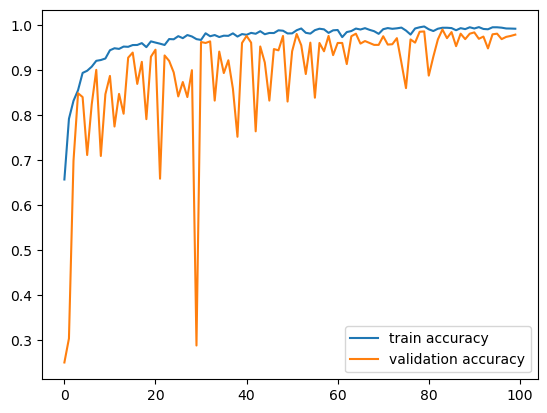

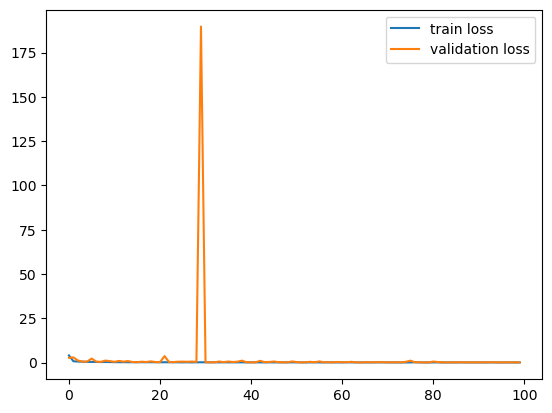

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()


In [ ]:
y_pred = model.predict(X_test)

44/44 [==============================] - 3s 28ms/step


44/44 [==============================] - 1s 27ms/step


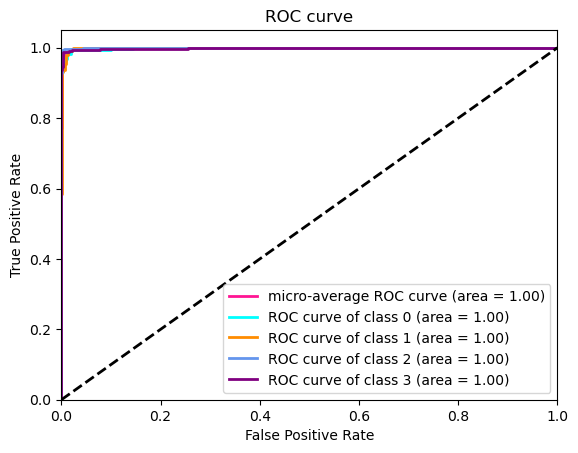

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

# Compute the predicted probabilities for each class
probas = model.predict(X_test)

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probas[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), probas.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curves
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=lw, label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'purple']
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,cohen_kappa_score

def evaluate_model(model, X_test, y_test, labels):
    # Make predictions on test data
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # Calculate the metrics
    loss, accuracy = model.evaluate(X_test, y_test)
    precision = accuracy_score(y_test_labels, y_pred_labels)*100
    kappa = cohen_kappa_score(y_test_labels, y_pred_labels)*100
    classification = classification_report(y_test_labels, y_pred_labels, target_names=labels)
    confusion = confusion_matrix(y_test_labels, y_pred_labels)
    accuracy=accuracy*100
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    ax.set_title("Confusion Matrix")
    plt.show()

    # Print the classification report
    print("Classification Report:\n", classification)

    # Print the metrics
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Kappa Score: {kappa:.4f}")
    return confusion, classification

44/44 [==============================] - 1s 28ms/step - loss: 0.0683 - accuracy: 0.9794


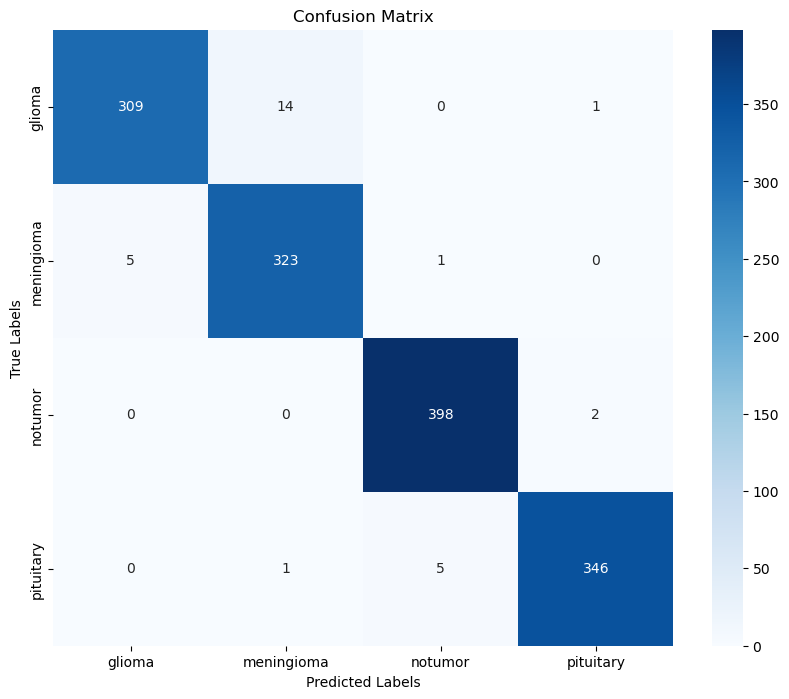

Classification Report:
               precision    recall  f1-score   support

      glioma       0.98      0.95      0.97       324
  meningioma       0.96      0.98      0.97       329
     notumor       0.99      0.99      0.99       400
   pituitary       0.99      0.98      0.99       352

    accuracy                           0.98      1405
   macro avg       0.98      0.98      0.98      1405
weighted avg       0.98      0.98      0.98      1405

Loss: 0.0683
Accuracy: 97.9359
Precision: 97.9359
Kappa Score: 97.2407


In [ ]:
target = ['glioma', 'meningioma', 'notumor', 'pituitary']
confusion, classification= evaluate_model(model, X_test, y_test, target)


In [ ]:
from tensorflow.keras.models import load_model
# Save the model to a file
model.save('inception-not-tf.h5')

In [ ]:
# Get the list of trainable layers in the model
trainable_layers = [layer for layer in model.layers if layer.trainable]

# Print the summary of trainable layers only
print("Trainable layers summary:")
for layer in trainable_layers:
    print(layer.name, layer.trainable, layer.output_shape)


Trainable layers summary:
input_1 True [(None, 128, 128, 3)]
conv2d True (None, 63, 63, 32)
batch_normalization True (None, 63, 63, 32)
activation True (None, 63, 63, 32)
conv2d_1 True (None, 61, 61, 32)
batch_normalization_1 True (None, 61, 61, 32)
activation_1 True (None, 61, 61, 32)
conv2d_2 True (None, 61, 61, 64)
batch_normalization_2 True (None, 61, 61, 64)
activation_2 True (None, 61, 61, 64)
max_pooling2d True (None, 30, 30, 64)
conv2d_3 True (None, 30, 30, 80)
batch_normalization_3 True (None, 30, 30, 80)
activation_3 True (None, 30, 30, 80)
conv2d_4 True (None, 28, 28, 192)
batch_normalization_4 True (None, 28, 28, 192)
activation_4 True (None, 28, 28, 192)
max_pooling2d_1 True (None, 13, 13, 192)
conv2d_8 True (None, 13, 13, 64)
batch_normalization_8 True (None, 13, 13, 64)
activation_8 True (None, 13, 13, 64)
conv2d_6 True (None, 13, 13, 48)
conv2d_9 True (None, 13, 13, 96)
batch_normalization_6 True (None, 13, 13, 48)
batch_normalization_9 True (None, 13, 13, 96)
activatio